In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import Libraries

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.checkpoint as C
import torchvision.transforms as T
import torchvision.transforms.functional as fn

from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models

!pip install /kaggle/input/segmentation-models-pytorch/timm-0.6.12-py3-none-any.whl
!pip install /kaggle/input/segmentation-models-pytorch/efficientnet_pytorch-0.7.1-py3-none-any.whl
!pip install /kaggle/input/segmentation-models-pytorch/munch-3.0.0-py2.py3-none-any.whl
!pip install /kaggle/input/segmentation-models-pytorch/pretrainedmodels-0.7.4-py3-none-any.whl
!pip install /kaggle/input/segmentation-models-pytorch/segmentation_models_pytorch-0.3.2-py3-none-any.whl

import segmentation_models_pytorch as smp

!pip install /kaggle/input/torch-summary/torchsummary-1.5.1-py3-none-any.whl
from torchsummary import summary

Processing /kaggle/input/segmentation-models-pytorch/timm-0.6.12-py3-none-any.whl
  Attempting uninstall: timm
    Found existing installation: timm 0.9.2
    Uninstalling timm-0.9.2:
      Successfully uninstalled timm-0.9.2
Processing /kaggle/input/segmentation-models-pytorch/efficientnet_pytorch-0.7.1-py3-none-any.whl
Processing /kaggle/input/segmentation-models-pytorch/munch-3.0.0-py2.py3-none-any.whl
Processing /kaggle/input/segmentation-models-pytorch/pretrainedmodels-0.7.4-py3-none-any.whl
Processing /kaggle/input/segmentation-models-pytorch/segmentation_models_pytorch-0.3.2-py3-none-any.whl
Processing /kaggle/input/torch-summary/torchsummary-1.5.1-py3-none-any.whl


In [3]:
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/timm-pretrained-resnest26/gluon_resnest26-50eb607c.pth /root/.cache/torch/hub/checkpoints/gluon_resnest26-50eb607c.pth

# Utilities

In [4]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    print(f'Using {device}')
    return device

device = get_device()

Using cuda


# Import Data

In [5]:
class Config:
    # path to data folder
    data_dir = '/kaggle/input/google-research-identify-contrails-reduce-global-warming'
    train_path = os.path.join(data_dir, 'train')
    val_path = os.path.join(data_dir, 'validation')
    test_path = os.path.join(data_dir, 'test')
    
    # base image size
    resize_value = 256
    
    # resize image
    resize = False
    if resize:
        resize_value = 384
    
    # model settings
    model = 'UNET'
    encoder = 'timm-resnest26d'
    weights = 'imagenet'
    
    epochs = 40
    batch_size = 16 #16
    lr = 5e-3
    optimizer = 'Adam'

# Create the Torch Dataset

In [6]:
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)
    
    
fraction = 50/100
def normalize_range(data, bounds):
    # maps data to the range[0,1]
    return (data - bounds[0]) / (bounds[1] - bounds[0])
    
def normalize_std(spec):
    return(spec-np.mean(spec))/np.std(spec)

class ContrailDataset(Dataset):
    def __init__(self, data_dir, mode = 'train'):
        
        self.data_dir = data_dir
#         self.file_name = os.listdir(data_dir)
        if 'train' in data_dir:
            temp_file_name = os.listdir(data_dir)
            used = int(len(temp_file_name)*fraction)
            print('{:d} records in train, fraction of {:f} loaded, {:d} recrods loaded '.format(len(temp_file_name), fraction, used))
            self.file_name = os.listdir(data_dir)[:used]
        elif 'validation' in data_dir: # validation
            temp_file_name = os.listdir(data_dir)
            used = int(len(temp_file_name)*fraction)
            print('{:d} records in validation, fraction of {:f} loaded, {:d} recrods loaded '.format(len(temp_file_name), fraction, used))
            self.file_name = os.listdir(data_dir)[:used]
        elif 'test' in data_dir: # test
            self.file_name = os.listdir(data_dir)
                          
                          
#         print(self.file_name)
        self.mode = mode
        
        self.resize_image = T.Resize(Config.resize_value, interpolation = T.InterpolationMode.BILINEAR,
                                    antialias = True)
        self.resize_mask = T.Resize(Config.resize_value, interpolation = T.InterpolationMode.NEAREST,
                                   antialias = True)
    

    
    def __len__(self):
        # returns the number of samples in dataset
        return len(self.file_name)
        
    def __getitem__(self, i):
        # loads and returns a sample from the dataset at the given index 
        band11 = np.load(os.path.join(self.data_dir, self.file_name[i], 'band_11.npy'))
        band14 = np.load(os.path.join(self.data_dir, self.file_name[i], 'band_14.npy'))
        band15 = np.load(os.path.join(self.data_dir, self.file_name[i], 'band_15.npy'))
            
        r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
        g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
        b = normalize_range(band14, _T11_BOUNDS)
        
        false_color = np.transpose(np.clip(np.stack([r,g,b], axis = 2), 0, 1)[:,:,:,4],(2,0,1))
        false_color = normalize_std(false_color)
        
        if self.mode == 'train':
            human_pixel_mask = np.load(os.path.join(self.data_dir, self.file_name[i],
                        'human_pixel_masks.npy')).astype(np.float32).transpose(2,0,1)
            
        elif self.mode == 'test':
            human_pixel_mask = self.file_name[i]
        else:
            human_pixel_mask = None
        
        return false_color, human_pixel_mask

band11 (256, 256, 8)
band14 (256, 256, 8)
band15 (256, 256, 8)
r (256, 256, 8)
g (256, 256, 8)
b (256, 256, 8)
After clip and stack (256, 256, 3, 8)
before transpose:  (256, 256, 3)
[0.095637  0.7042304 0.7834071]
after transpose:  (3, 256, 256)
false color:  (3, 256, 256)


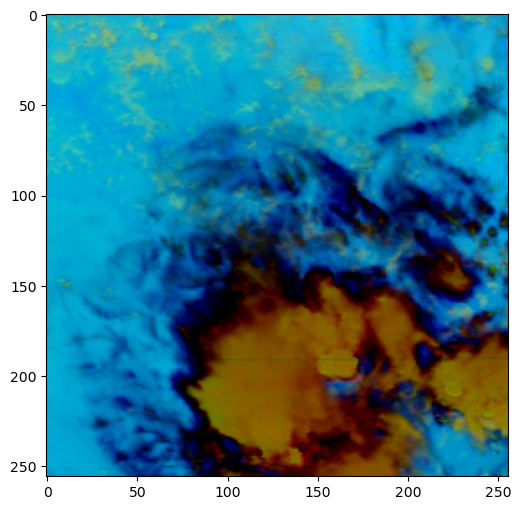

In [7]:
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    # maps data to the range[0,1]
    return (data - bounds[0]) / (bounds[1] - bounds[0])
    
def normalize_std(spec):
    return(spec-np.mean(spec))/np.std(spec)

band11_test = np.load('/kaggle/input/google-research-identify-contrails-reduce-global-warming/train/1000216489776414077/band_11.npy')
band14_test = np.load('/kaggle/input/google-research-identify-contrails-reduce-global-warming/train/1000216489776414077/band_14.npy')
band15_test = np.load('/kaggle/input/google-research-identify-contrails-reduce-global-warming/train/1000216489776414077/band_15.npy')

r_test = normalize_range(band15_test - band14_test, _TDIFF_BOUNDS)
g_test = normalize_range(band14_test - band11_test, _CLOUD_TOP_TDIFF_BOUNDS)
b_test = normalize_range(band14_test, _T11_BOUNDS)

print('band11',band11_test.shape)
print('band14',band14_test.shape)
print('band15',band15_test.shape)

print('r',r_test.shape)
print('g',g_test.shape)
print('b',b_test.shape)

clip_stack = np.clip(np.stack([r_test,g_test,b_test], axis = 2), 0, 1)
print('After clip and stack', clip_stack.shape)

before_transpose = clip_stack[:,:,:,4]
after_transpose = np.transpose(before_transpose, (2,0,1))
print('before transpose: ', before_transpose.shape)
print(before_transpose[0][0])
print('after transpose: ', after_transpose.shape)

false_color_test = normalize_std(after_transpose)
print('false color: ', false_color_test.shape)
# false_color = np.transpose(np.clip(np.stack([r,g,b], axis = 2), 0, 1)[:,:,:,4],(2,0,1))
# false_color = normalize_std(false_color)

plt.figure(figsize=(6,6))
ax = plt.subplot(1,1,1)
ax.imshow(before_transpose)

20529 records in train, fraction of 0.500000 loaded, 10264 recrods loaded 
dataset:  10264
a:  (3, 256, 256)
b:  (1, 256, 256)
a_transpose:  (256, 256, 3)
[-1.317837    0.09456838  1.4377766 ]
b_transpose:  (256, 256, 1)


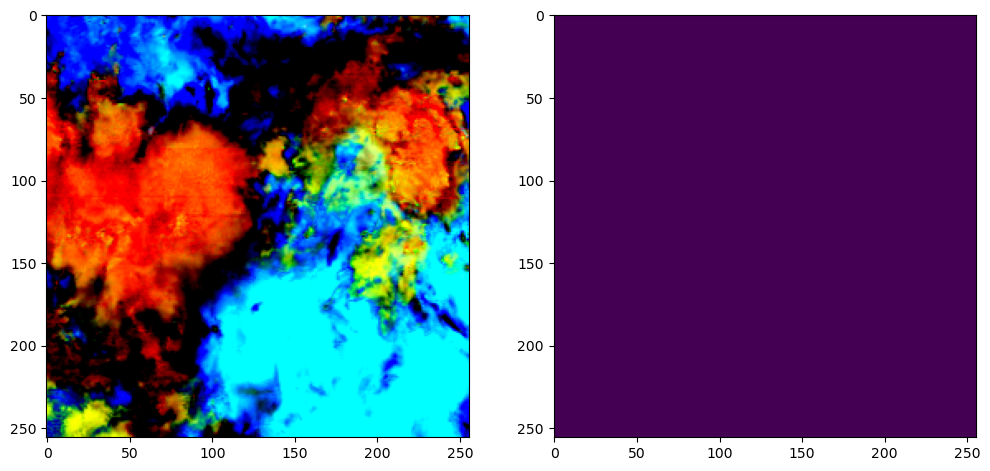

In [8]:
dataset = ContrailDataset(Config.train_path)
print('dataset: ', len(dataset))
a, b = dataset[1]
print('a: ', a.shape)
print('b: ', b.shape)

plt.figure(figsize=(12,6))
ax = plt.subplot(1,2,1)
a_transpose = np.transpose(a,(1,2,0))
ax.imshow(a_transpose)
print('a_transpose: ', a_transpose.shape)
print(a_transpose[0][0])
ax = plt.subplot(1,2,2)
b_transpose = np.transpose(b,(1,2,0))
ax.imshow(b_transpose, interpolation = 'none')
print('b_transpose: ', b_transpose.shape)
plt.show()

# Create the Training and Validation Dataloader

In [9]:
training_data = ContrailDataset(data_dir = Config.train_path)
train_dataloader = DataLoader(training_data,
                             batch_size = Config.batch_size,
                             shuffle = True,
                             num_workers = 2 if torch.cuda.is_available() else 0,
                             pin_memory = True,
                             drop_last = True)

validation_data = ContrailDataset(data_dir = Config.val_path)
validation_dataloader = DataLoader(validation_data,
                                  batch_size = Config.batch_size,
                                  shuffle = False,
                                  num_workers = 2 if torch.cuda.is_available() else 0,
                                  pin_memory = True,
                                  drop_last = True)

print('train_dataloader:', train_dataloader)
print('validation_dataloader:', validation_dataloader )

20529 records in train, fraction of 0.500000 loaded, 10264 recrods loaded 
1856 records in validation, fraction of 0.500000 loaded, 928 recrods loaded 
train_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7e2e27117130>
validation_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7e2ee8f7da20>


# Show Some Image from the Dataloaders

validation dataloader:  <torch.utils.data.dataloader.DataLoader object at 0x7e2ee8f7da20>
image:  torch.Size([16, 3, 256, 256])
mask:  torch.Size([16, 1, 256, 256])
after moveaxis
image:  torch.Size([16, 256, 256, 3])
mask:  torch.Size([16, 256, 256, 1])


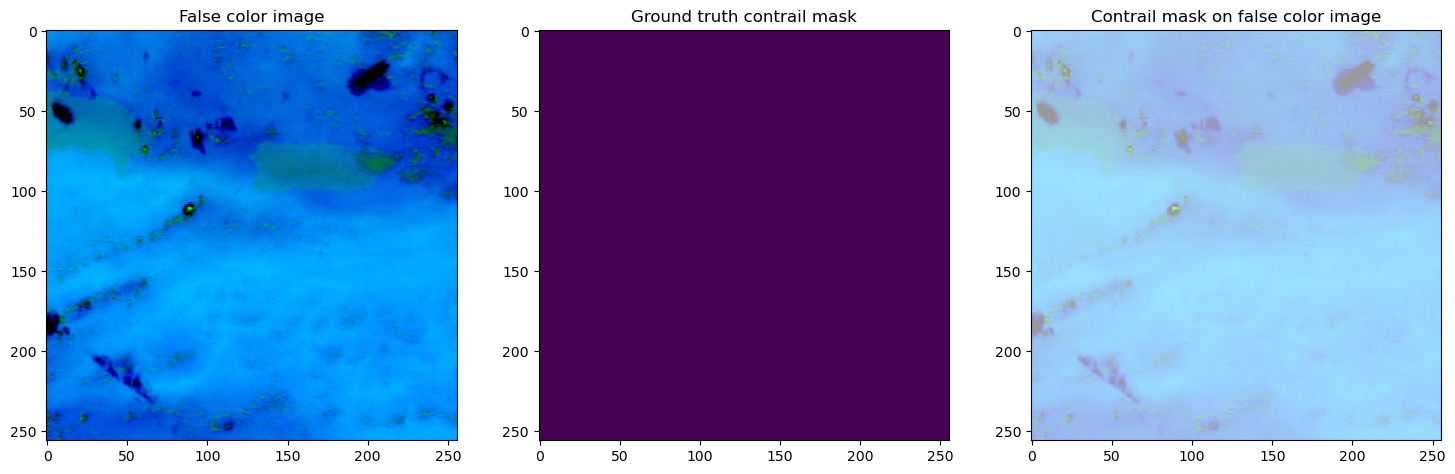

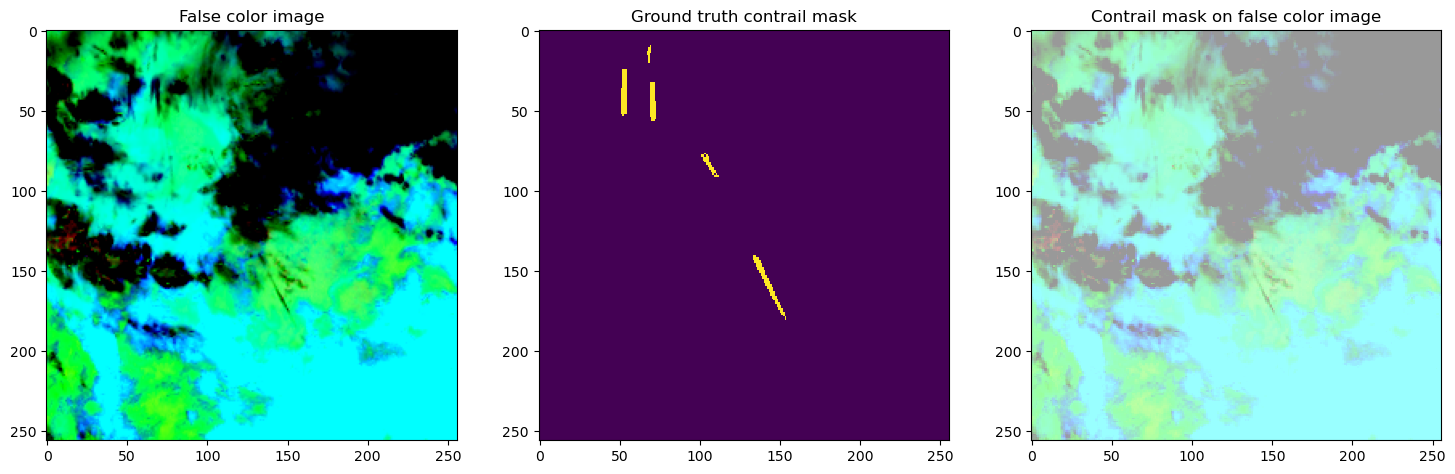

In [10]:
print('validation dataloader: ', validation_dataloader)
image, mask = next(iter(validation_dataloader))
print('image: ', image.shape)
print('mask: ', mask.shape)

image = torch.moveaxis(image, 1, -1)
mask = torch.moveaxis(mask, 1, -1)
print('after moveaxis')
print('image: ', image.shape)
print('mask: ', mask.shape)

for i in range(2):
    plt.figure(figsize=(18,6))
    
    ax = plt.subplot(1,3,1)
    ax.imshow(image[i])
    ax.set_title('False color image')
    
    ax = plt.subplot(1,3,2)
    ax.imshow(mask[i], interpolation = 'none')
    ax.set_title('Ground truth contrail mask')
    
    ax = plt.subplot(1,3,3)
    ax.imshow(image[i], cmap = 'Reds', alpha = .4, interpolation = 'none')
    ax.set_title('Contrail mask on false color image')

# Create the Model UNET

In [11]:
if Config.model == 'UNET':
    model = smp.Unet(encoder_name = Config.encoder, encoder_weights = Config.weights, 
                 in_channels = 3, activation = 'sigmoid')
    model.to(device)
    summary(model,(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,216
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          18,432
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
        MaxPool2d-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]           4,096
      BatchNorm2d-12           [-1, 64, 64, 64]             128
             ReLU-13           [-1, 64, 64, 64]               0
           Conv2d-14          [-1, 128,

# Optimizer

In [12]:
optimizer = optim.Adam(model.parameters(), lr = Config.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 1,
                                                      factor = 0.5, verbose = True)
print(f'Learning rate: {optimizer.param_groups[0]["lr"]}')

Learning rate: 0.005


# Loss Function

In [13]:
# average dice score for the example in a batch
def dice_avg(y_p, y_t, smooth = 1e-3):
    i = torch.sum(y_p * y_t, dim = (2,3))
#     print('i:',i)
    u = torch.sum(y_p, dim = (2,3)) + torch.sum(y_t, dim = (2, 3))
#     print('u:',u)
    score = (2 * i + smooth) / (u + smooth)
    return torch.mean(score)

def dice_loss_avg(y_p, y_t):
    return 1- dice_score_jan(y_p, y_t)

In [14]:
def dice_global(y_p, y_t, smooth = 1e-3):
    intersection = torch.sum(y_p * y_t)
#     print('intersection:',intersection)
    union = torch.sum(y_p) + torch.sum(y_t)
#     print('union:',union)
    dice = (2.0 * intersection + smooth) / (union + smooth)
        
    return dice

    
def dice_loss_global(y_p, y_t):
    return 1 - dice_global(y_p, y_t)

# Training and Validation Loop

In [15]:
train_dice_global_test = []
train_dice_avg_test = []
eval_dice_global_test = []
eval_dice_avg_test = []


model.train()
bar_test = tqdm(train_dataloader)
tot_loss_global_test = 0
tot_dice_global_test = 0
tot_dice_avg_test = 0
# print(bar_test)
count = 0
for image, mask in bar_test:
#         print('image:',image.shape)
#         print('mask:',mask.shape)
        image = torch.nn.functional.interpolate(image,
                                               size = Config.resize_value,
                                               mode = 'bilinear')
        # transfer to device
        image, mask = image.to(device), mask.to(device)
        
        # set optimizere gradients to zero
        optimizer.zero_grad()
        
        # perform inference
        pred_mask = model(image)
        
        # if the image was resized, use a resizing step to make 256 again
        if Config.resize:
            pred_mask = torch.nn.functional.interpolate(pred_mask,
                                                       size = 256,
                                                       mode = 'bilinear')
        
        # calculate the loss and do a backward pass
        loss = dice_loss_global(pred_mask, mask)
        loss.backward()
        
        # adjust the weights
        optimizer.step()
        
        tot_loss_global_test += loss.item()
#         print('loss:', loss.item())
        tot_dice_global_test += 1 - loss.item()
#         print('dice:', 1-loss.item())
        loss_avg = dice_avg(pred_mask, mask).item()
#         print('dice avg:', loss_avg)
        tot_dice_avg_test += loss_avg
        
        count += 1
        bar_test.set_postfix(TrainDiceLossGlobal = f'{tot_loss_global_test/count: .4f}',
                       TrainDiceGlobal = f'{tot_dice_global_test/count: .4f}',
                       TrainDiceAvg = f'{tot_dice_avg_test/count: .4f}')
        

  0%|          | 0/641 [00:00<?, ?it/s]

In [16]:
train_dice_global = []
train_dice_avg = []
eval_dice_global = []
eval_dice_avg = []
bst_dice = 0
bst_epoch = 1

for epoch in range(1, Config.epochs + 1):
    print(f'----------epoch: {epoch}----------')
    
    # early stopping
    if epoch-bst_epoch >= 10:
        print(f'early stopping in epoch {epoch}')
        break
        
    model.train()
    bar = tqdm(train_dataloader)
    tot_loss_global = 0
    tot_dice_global = 0
    tot_dice_avg = 0
    count = 0
    
    for image, mask in bar:
        
        image = torch.nn.functional.interpolate(image,
                                               size = Config.resize_value,
                                               mode = 'bilinear')
        # transfer to device
        image, mask = image.to(device), mask.to(device)
        
        # set optimizere gradients to zero
        optimizer.zero_grad()
        
        # perform inference
        pred_mask = model(image)
        
        # if the image was resized, use a resizing step to make 256 again
        if Config.resize:
            pred_mask = torch.nn.functional.interpolate(pred_mask,
                                                       size = 256,
                                                       mode = 'bilinear')
        
        # calculate the loss and do a backward pass
        loss = dice_loss_global(pred_mask, mask)
        loss.backward()
        
        # adjust the weights
        optimizer.step()
        
        tot_loss_global += loss.item()
        tot_dice_global += 1 - loss.item()
        tot_dice_avg += dice_avg(pred_mask, mask).item()
        
        count += 1
        bar.set_postfix(TrainDiceLossGlobal = f'{tot_loss_global/count: .4f}',
                       TrainDiceGlobal = f'{tot_dice_global/count: .4f}',
                       TrainDiceAvg = f'{tot_dice_avg/count: .4f}')
        
    train_dice_global.append(np.array(tot_dice_global/count))
    train_dice_avg.append(np.array(tot_dice_avg/count))
        
    model.train(False)
    bar = tqdm(validation_dataloader)
    tot_dice_global = 0
    tot_dice_avg = 0
    count = 0
        
    for image, mask in bar:
        if Config.resize:
            image = torch.nn.functional.interpolate(image, size = Config.resize_value, mode = 'bilinear')
                
        image, mask = image.to(device), mask.to(device)
        pred_mask = model(image)
        
        if Config.resize:
            pred_mask = torch.nn.functional.interpolate(pred_mask, size = 256, mode = 'bilinear')
            
        tot_dice_global += dice_global(pred_mask, mask).item()
        tot_dice_avg += dice_avg(pred_mask, mask).item()
        count += 1
        bar.set_postfix(ValidDiceGlobal = f'{tot_dice_global/count: .4f}',
                        ValidDiceAcg = f'{tot_dice_avg/count: .4f}')
        
    eval_dice_global.append(np.array(tot_dice_global/count))
    eval_dice_avg.append(np.array(tot_dice_avg/count))
    scheduler.step(1-(tot_dice_global/count))
    print(f'learning rate: {optimizer.param_groups[0]["lr"]}')
        
    if tot_dice_global/count > bst_dice:
        bst_dice = tot_dice_global/count
        bst_epoch = epoch
        torch.save(model.state_dict(), f'model_state_dict_epoch_{epoch}_dice_{bst_dice: .4f}.pth')
        torch.save(model, f'model_epoch{epoch}_dice_{bst_dice: .4f}.pt')
        print(f'current model saved! Epoch:{epoch} global dice: {bst_dice} avg dice: {tot_dice_avg/count}')

----------epoch: 1----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

learning rate: 0.005
current model saved! Epoch:1 global dice: 0.347643858152593 avg dice: 0.23480328082524496
----------epoch: 2----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

learning rate: 0.005
current model saved! Epoch:2 global dice: 0.4307735179463105 avg dice: 0.6415111879850256
----------epoch: 3----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

learning rate: 0.005
----------epoch: 4----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 00004: reducing learning rate of group 0 to 2.5000e-03.
learning rate: 0.0025
----------epoch: 5----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

learning rate: 0.0025
current model saved! Epoch:5 global dice: 0.5056620444367252 avg dice: 0.6910909917847864
----------epoch: 6----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

learning rate: 0.0025
----------epoch: 7----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 1.2500e-03.
learning rate: 0.00125
----------epoch: 8----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

learning rate: 0.00125
current model saved! Epoch:8 global dice: 0.5211136662376169 avg dice: 0.722567390265136
----------epoch: 9----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

learning rate: 0.00125
current model saved! Epoch:9 global dice: 0.5318732762661085 avg dice: 0.7238966637644274
----------epoch: 10----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

learning rate: 0.00125
----------epoch: 11----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 6.2500e-04.
learning rate: 0.000625
----------epoch: 12----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

learning rate: 0.000625
current model saved! Epoch:12 global dice: 0.5371686486032539 avg dice: 0.7394045072382894
----------epoch: 13----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

learning rate: 0.000625
current model saved! Epoch:13 global dice: 0.5477490832623391 avg dice: 0.731485547690556
----------epoch: 14----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

learning rate: 0.000625
----------epoch: 15----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 00015: reducing learning rate of group 0 to 3.1250e-04.
learning rate: 0.0003125
----------epoch: 16----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

learning rate: 0.0003125
----------epoch: 17----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 00017: reducing learning rate of group 0 to 1.5625e-04.
learning rate: 0.00015625
----------epoch: 18----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

learning rate: 0.00015625
----------epoch: 19----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 00019: reducing learning rate of group 0 to 7.8125e-05.
learning rate: 7.8125e-05
----------epoch: 20----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

learning rate: 7.8125e-05
----------epoch: 21----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Epoch 00021: reducing learning rate of group 0 to 3.9063e-05.
learning rate: 3.90625e-05
----------epoch: 22----------


  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

learning rate: 3.90625e-05
----------epoch: 23----------
early stopping in epoch 23


# Training and Validation History

<function matplotlib.pyplot.show(close=None, block=None)>

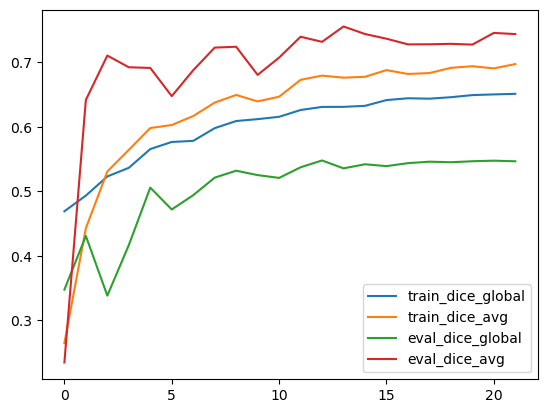

In [17]:
plt.plot(train_dice_global, label = 'train_dice_global')
plt.plot(train_dice_avg, label = 'train_dice_avg')
plt.plot(eval_dice_global, label = 'eval_dice_global')
plt.plot(eval_dice_avg, label = 'eval_dice_avg')
plt.legend()
plt.show

# Show Some Predictions for the Validation Dataset

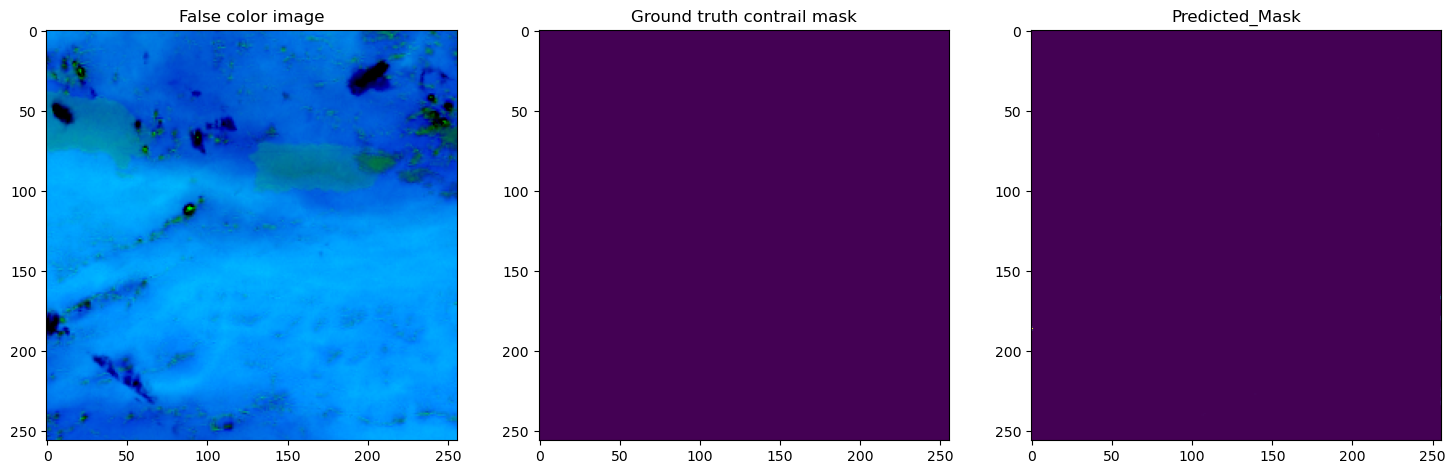

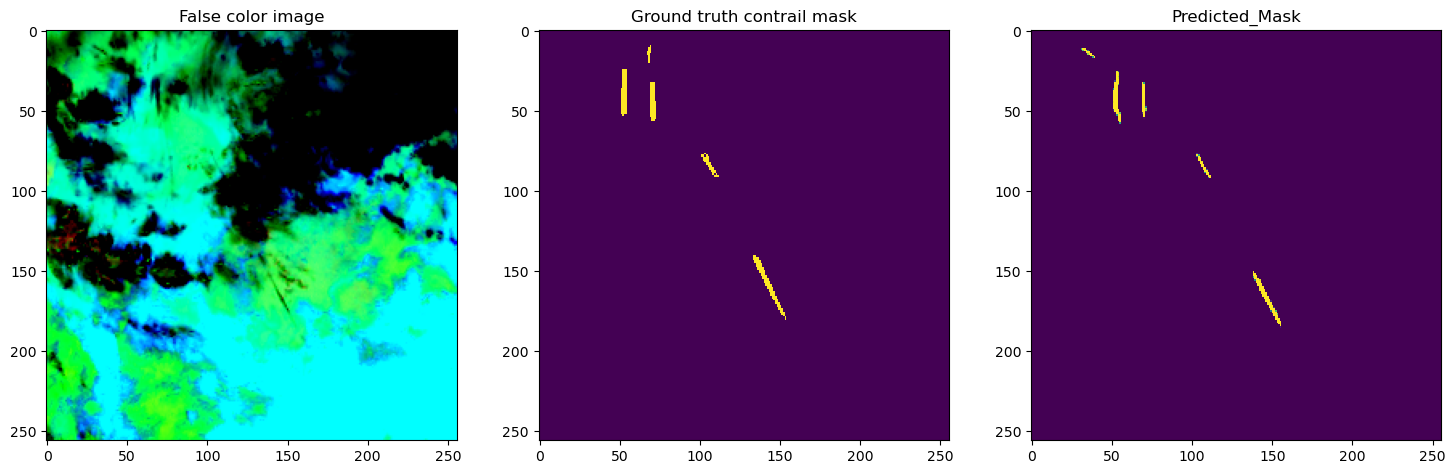

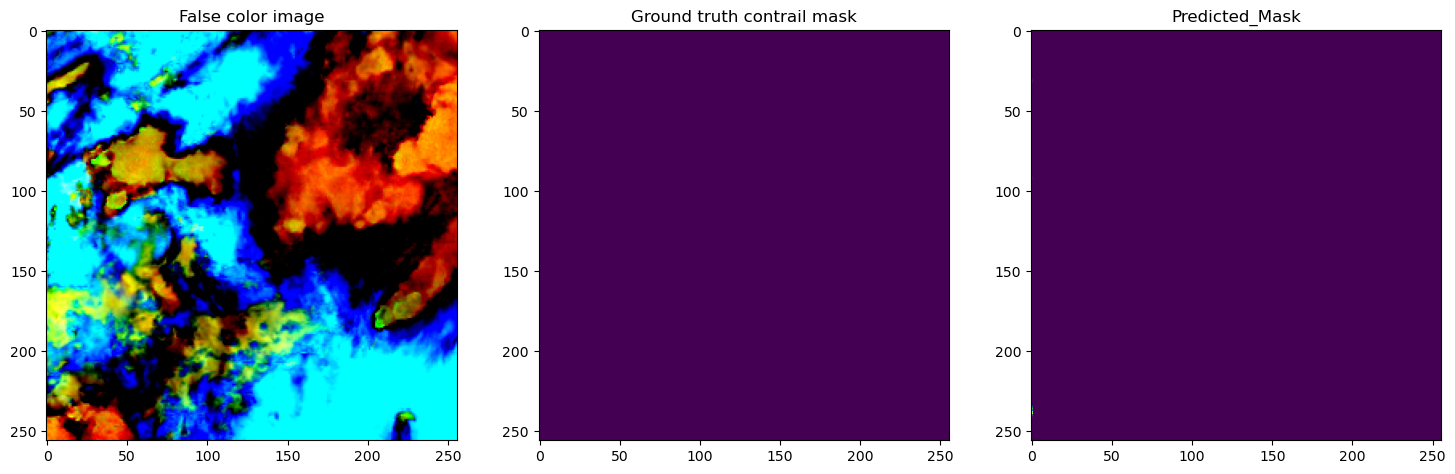

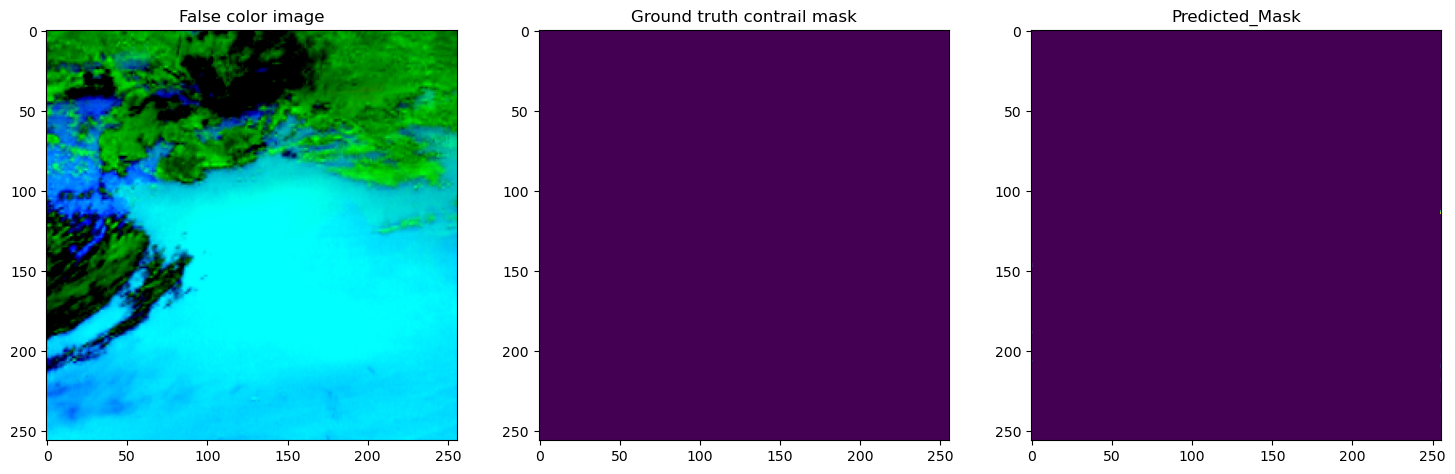

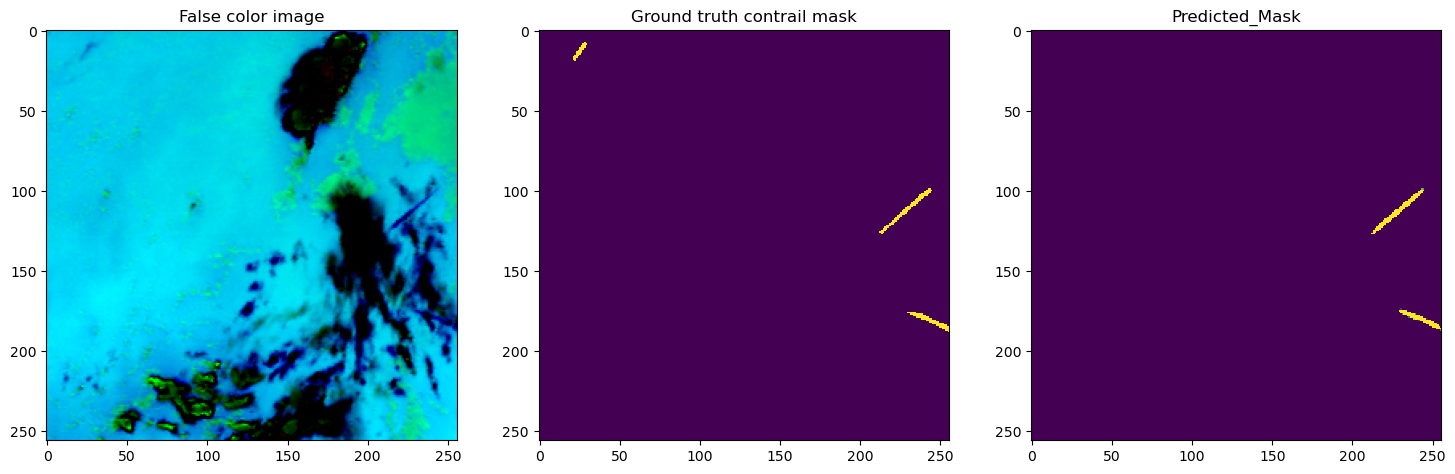

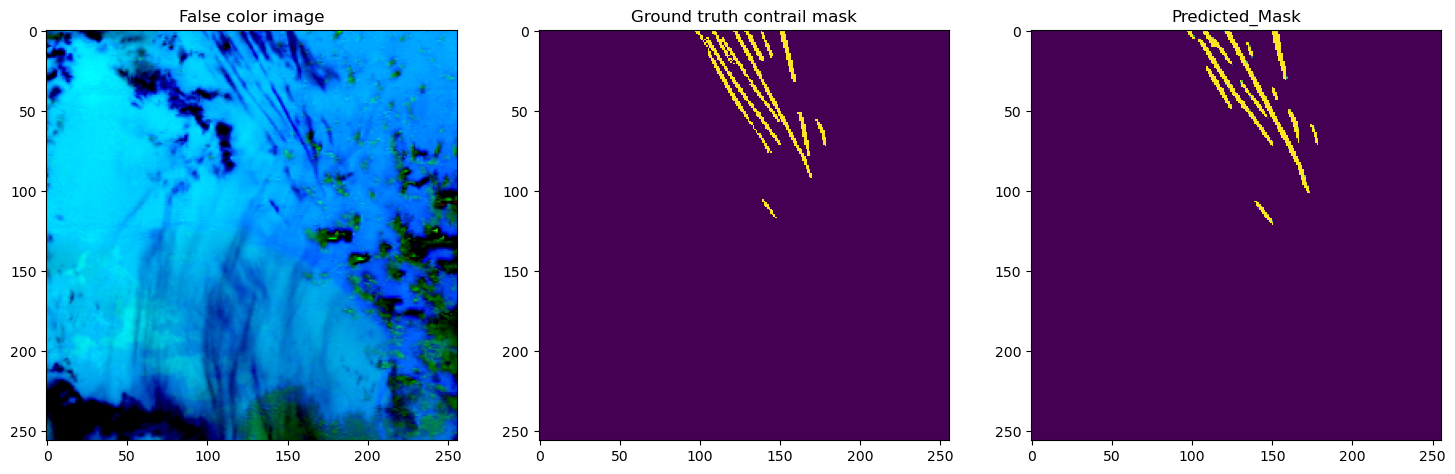

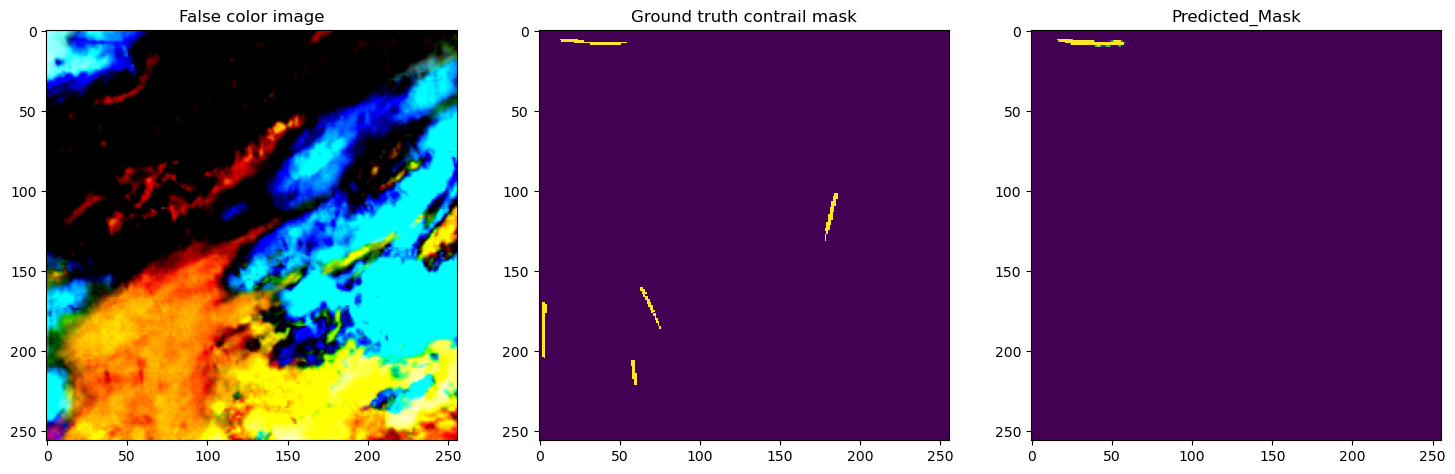

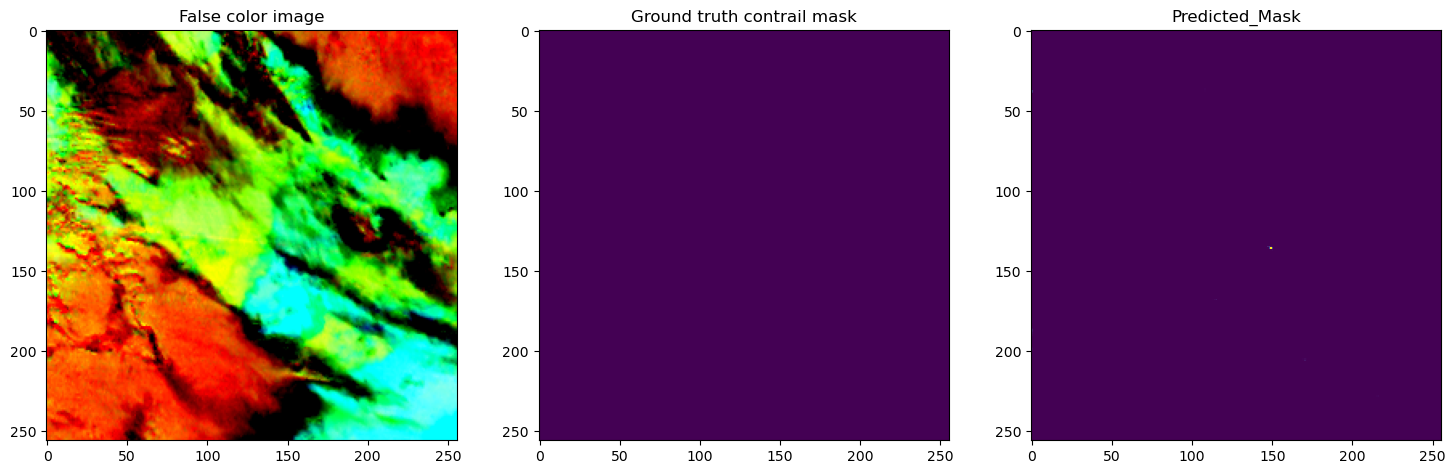

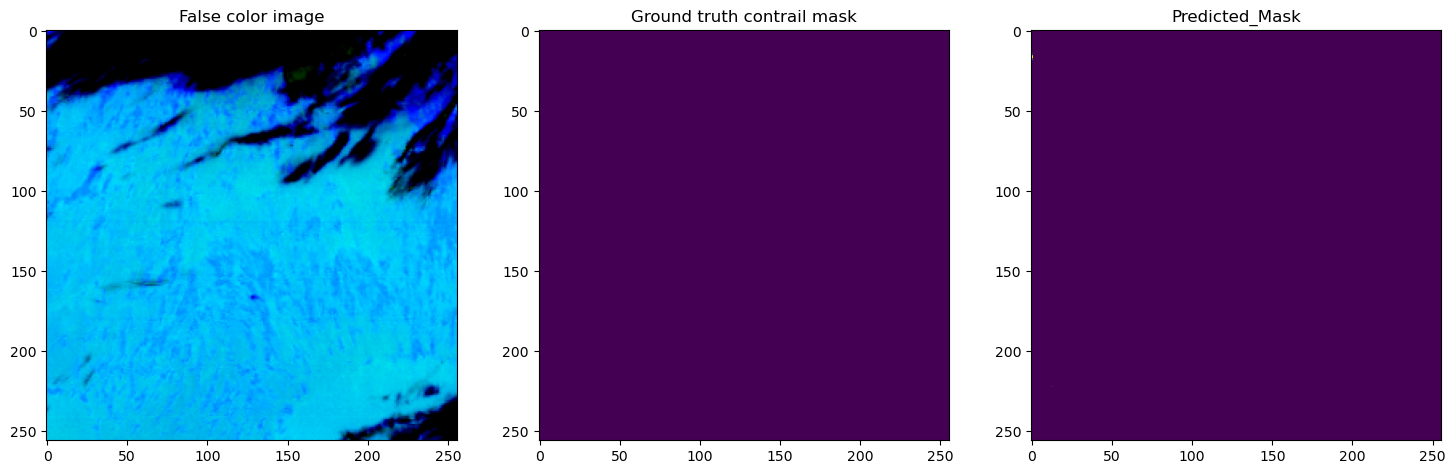

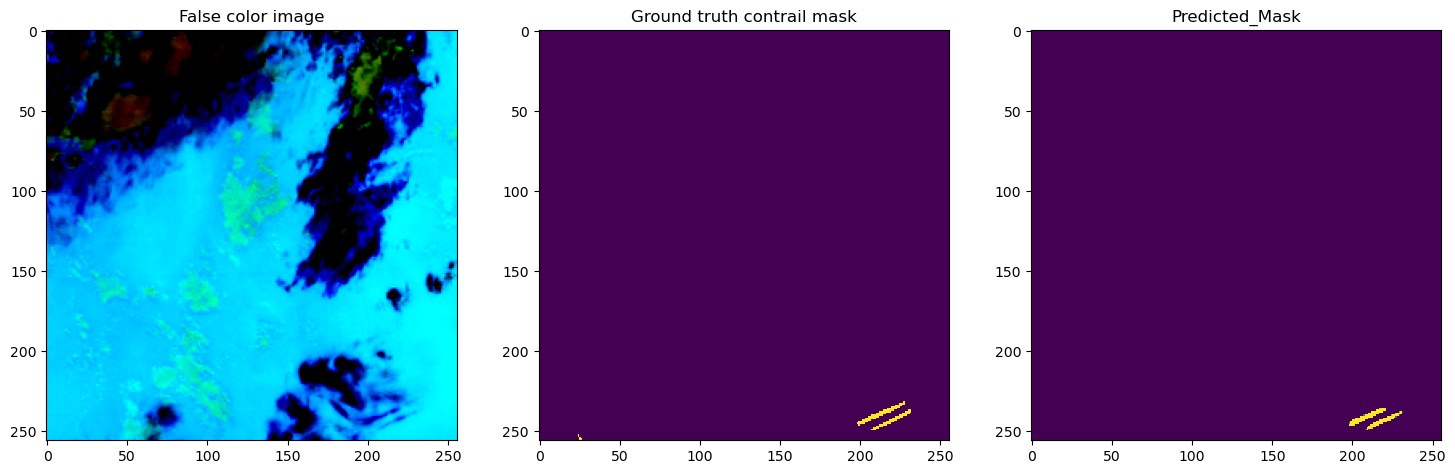

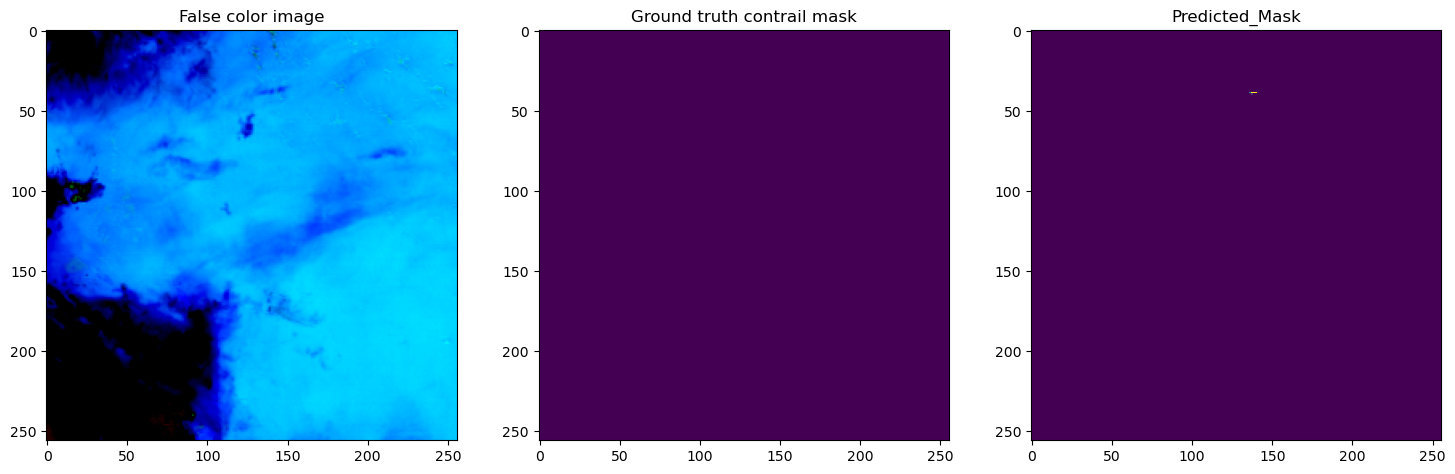

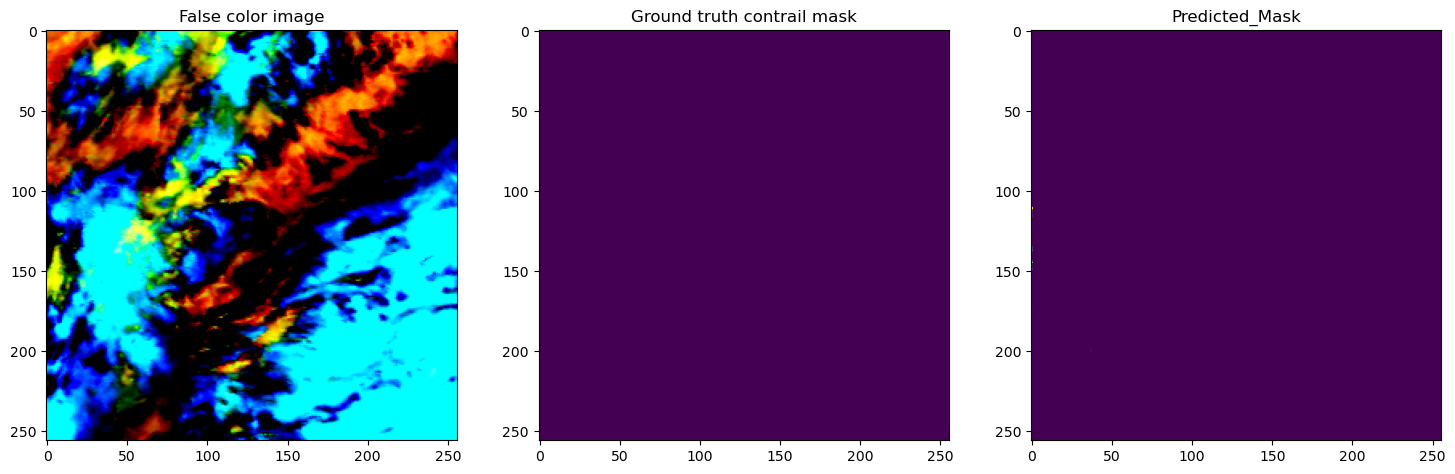

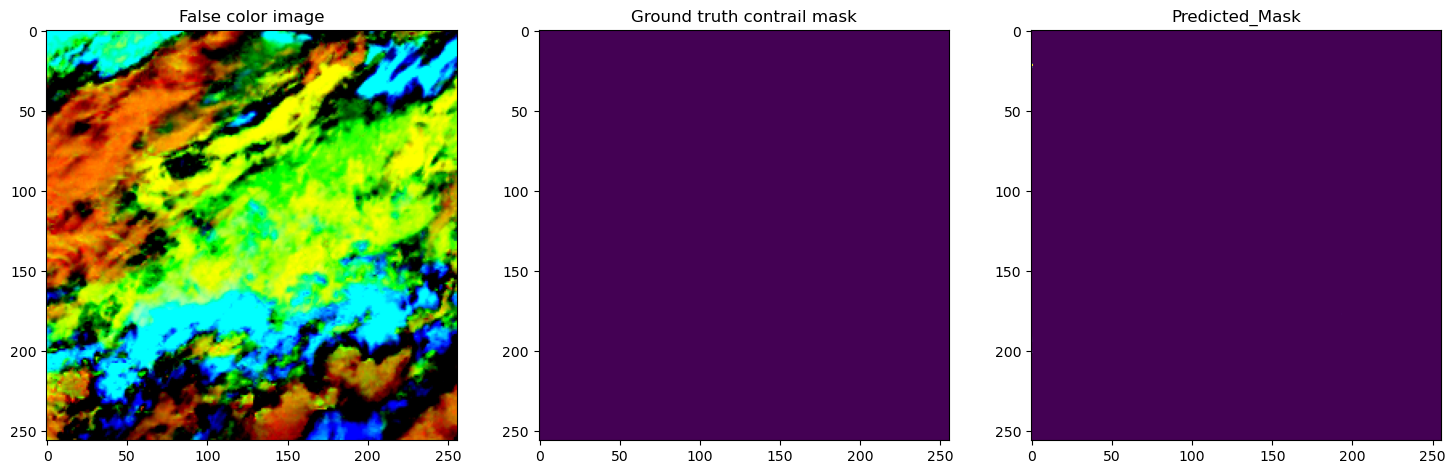

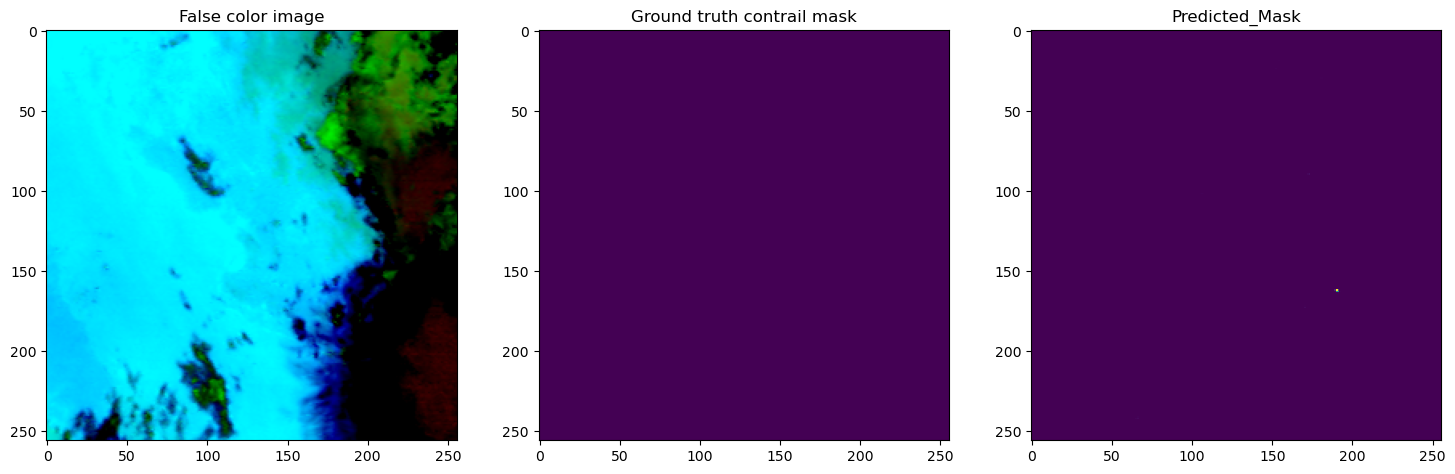

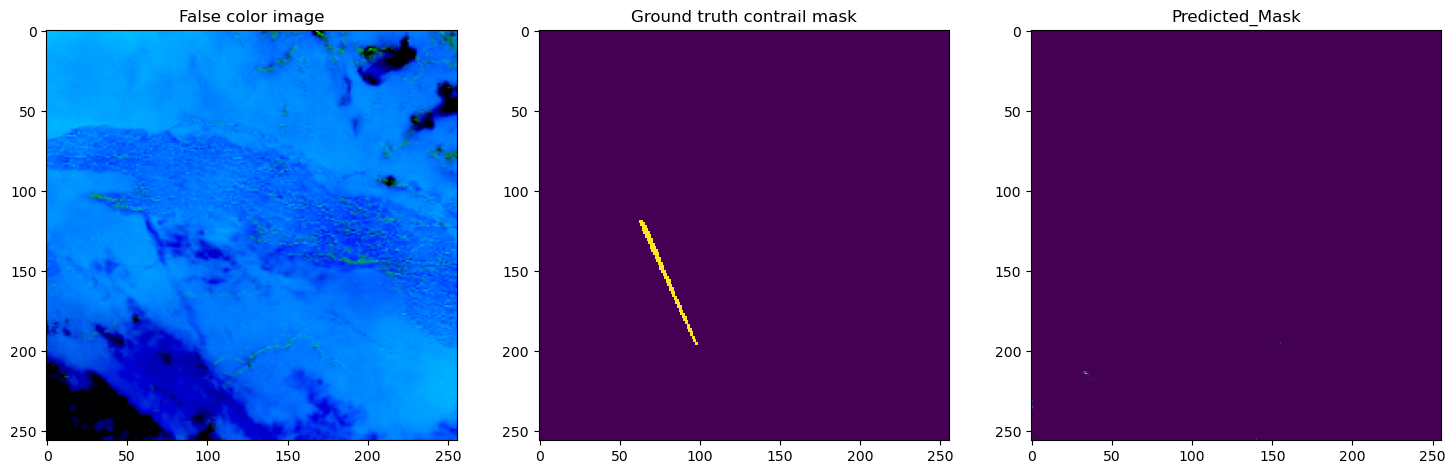

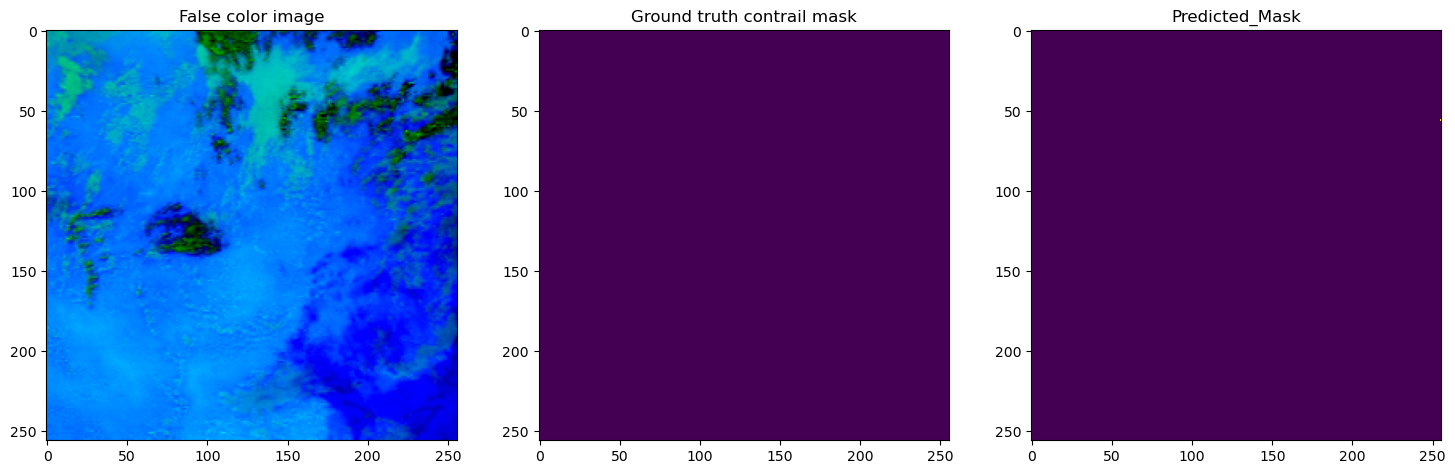

In [18]:
image, mask = next(iter(validation_dataloader))

image, mask = image.to(device), mask.to(device)
pred_mask = model(image)

image = torch.moveaxis(image, 1, -1)
mask = torch.moveaxis(mask, 1, -1)
pred_mask = torch.moveaxis(pred_mask, 1, -1)

image, mask, pred_mask = image.cpu(), mask.cpu(), pred_mask.detach().cpu()

for i in range(Config.batch_size):
    plt.figure(figsize=(18, 6))
    
    ax = plt.subplot(1, 3, 1)
    ax.imshow(image[i])
    ax.set_title('False color image')
    
    ax = plt.subplot(1, 3, 2)
    ax.imshow(mask[i], interpolation = 'none')
    ax.set_title('Ground truth contrail mask')
    
    ax = plt.subplot(1, 3, 3)
    ax.imshow(pred_mask[i], interpolation = 'none')
    ax.set_title('Predicted_Mask')

# Run-Length Code

In [19]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s


def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''

    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    if mask_rle != '-': 
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

# Create a Naive Submission

In [20]:
test_recs = os.listdir(Config.test_path)
# print(test_recs)

In [21]:
test_data = ContrailDataset(data_dir = Config.test_path, mode='test')
test_dataloader = DataLoader(test_data,
                             batch_size = Config.batch_size,
                             shuffle = False,
                             num_workers = 2 if torch.cuda.is_available() else 0,
                             pin_memory = True,
                             drop_last = False)
print('test_dataloader:',test_dataloader)
submission = pd.read_csv('/kaggle/input/google-research-identify-contrails-reduce-global-warming/sample_submission.csv', 
                         index_col='record_id')

model.eval()
fails = []

with torch.no_grad():
    for X, rec in test_dataloader:
        mask = np.zeros((256,256))
        try:
            print('X:',X.shape)
            X = X.to(device)
    #         print(model(X))
    #         pred = (model(X)['out']).cpu().detach().numpy().copy()[0,0,:,:]
            pred = model(X).cpu().numpy().copy()[0,0,:,:]
            # if the image was resized, use a resizing step to make 256 again
            if Config.resize:
                pred = torch.nn.functional.interpolate(pred,
                                                       size = 256,
                                                       mode = 'bilinear')
            mask[pred < 0.5] = 0
            mask[pred > 0.5] = 1
        except Exception as e:
            fails.append(e)
            continue
        
        submission.loc[int(rec[0]), 'encoded_pixels'] = list_to_string(rle_encode(mask))
        
submission.head()

test_dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7e2dfc211a20>
X: torch.Size([2, 3, 256, 256])


encoded_pixels
record_id                         
1000834164244036115       1 3 10 5
1002653297254493116              -

In [22]:
submission.to_csv('submission.csv')

In [23]:
import IPython.display as ipd

audio_path="/kaggle/input/music-notification-rome-legion/rome-legion-62972.mp3"

ipd.Audio(audio_path, autoplay=True)